In [1]:
import models
from  models.simplenet import SimpleNet
import torch.optim as optim
import torch.nn as nn


model = SimpleNet(num_classes=10, in_chans= 1, scale=1, network_idx=1, mode=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
import torchvision
import torchvision.transforms as transforms
import os
import torch

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
notebook_directory = os.path.dirname(os.path.abspath("deep_ensemble_mnist.ipynb"))

# Navigate to the parent folder (assuming "usr" and "home" are at the same level)
parent_directory = os.path.abspath(os.path.join(notebook_directory, "..","..","..","..","..","..",".."))
# Construct the path to the ImageNet directory
mnist_directory = os.path.abspath(os.path.join(parent_directory, "/usr/data1/vision/data/"))
# Download the training dataset
train_dataset = torchvision.datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)

# Download the testing dataset
test_dataset = torchvision.datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform)

train_loader128 = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=64)

In [3]:
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch + 1} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Testing
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset) * 100
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)')

print("Training complete!")


NameError: name 'train_loader' is not defined

In [38]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

#load densenet

# densenet = densenet121(pretrained=False).cuda()
# densenet.eval()

epochs = 100
one_particle_params = push.bayes.ensemble.train_deep_ensemble(
        train_loader128,
        torch.nn.CrossEntropyLoss(),
        epochs,
        SimpleNet, 10, 1, 1, 1, 2,
        num_devices=2,
        num_ensembles=1,
    )

100%|██████████| 100/100 [50:27<00:00, 30.28s/it]


In [44]:
def get_ensemble_models(paramList, num_ensembles, num_classes, in_chans, scale, network_idx, mode):
    models = []
    for i in range(num_ensembles):
        model = SimpleNet(num_classes, in_chans, scale, network_idx, mode)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models
one_particle_models = get_ensemble_models(two_particle_params, num_ensembles=1, num_classes=10, in_chans= 1, scale=1, network_idx=1, mode=2)
# two_particle_models = get_ensemble_models(two_particle_params, num_ensembles=2, num_classes=10, in_chans= 1, scale=1, network_idx=1, mode=2)
# four_particle_models = get_ensemble_models(four_particle_params, num_ensembles=4, n=4, input_dim=1, hidden_dim=64)
# eight_particle_models = get_ensemble_models(eight_particle_params, num_ensembles=8, n=4, input_dim=1, hidden_dim=64)

In [45]:
import torch

def get_ensemble_output(modelList, dataloader, num_ensembles):
    outputs = []
    probabilities = []
    for i in range(num_ensembles):
        model_i_output = []
        model_i_probabilities = []
        for data, target in dataloader:
            output = modelList[i](data).detach()
            model_i_output.append(output)
            softmax_output = torch.nn.functional.softmax(output, dim=1)
            model_i_probabilities.append(softmax_output)
        outputs.append(model_i_output)
        probabilities.append(model_i_probabilities)
    return outputs, probabilities



# Predictions for out of sample
one_model_outputs, one_model_probabilities = get_ensemble_output(one_particle_models, test_loader, 1)

# two_model_outputs, two_model_probabilities = get_ensemble_output(two_particle_models, test_loader, 2)
# four_model_outputs = get_ensemble_output(four_particle_models, test_loader, 4)
# eight_model_outputs = get_ensemble_output(eight_particle_models, test_loader, 8)




In [46]:
one_model_outputs

[[tensor([[-1.0241e+00, -1.1941e+00, -7.5381e-01, -8.9725e-01, -1.1125e+00,
           -1.4083e+00, -1.3902e+00,  6.4194e+00, -1.4024e+00, -3.9445e-01],
          [-9.9480e-01, -2.5858e-03,  5.7742e+00, -6.1096e-01, -8.5643e-01,
           -8.9034e-01, -1.1992e-01, -1.5669e+00, -5.2637e-01, -9.7867e-01],
          [-1.4361e+00,  5.3245e+00, -3.9606e-01, -1.1479e+00, -1.1418e+00,
           -9.6187e-01, -1.2859e+00, -1.0170e+00, -5.4050e-01, -7.8226e-01],
          [ 5.5895e+00, -9.1348e-01,  1.0608e-01, -7.7833e-01, -1.0824e+00,
           -9.6849e-01, -3.5245e-01, -5.7351e-01, -1.1003e+00, -5.0431e-01],
          [-1.5830e+00, -7.2178e-01, -6.9929e-01, -1.7835e+00,  4.0815e+00,
           -6.7812e-01, -1.3908e+00, -1.2106e+00, -3.2983e-01,  2.3300e+00],
          [-1.4736e+00,  5.7974e+00, -8.8262e-01, -1.1160e+00, -1.2105e+00,
           -1.0161e+00, -1.4688e+00, -9.7268e-01, -4.4552e-01, -7.2736e-01],
          [-1.1130e+00, -7.6455e-01, -1.0568e+00, -1.4994e+00,  3.3490e+00,
      

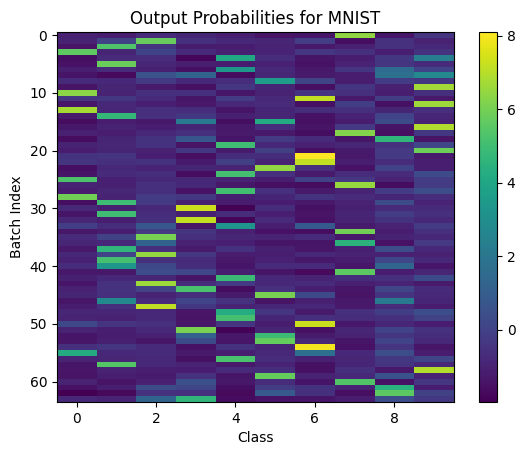

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming output is your provided list
output_tensor = one_model_outputs[0][0].numpy()

# Plotting the heatmap
plt.imshow(output_tensor, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Class')
plt.ylabel('Batch Index')
plt.title('Output Probabilities for MNIST')
plt.show()


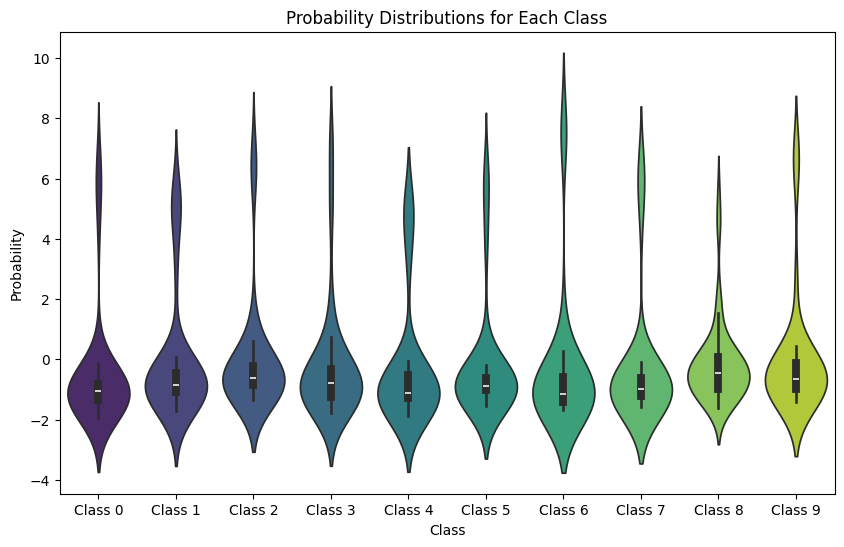

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming output is your provided list
output_tensor = one_model_outputs[0][0].numpy()

# Create a list of labels for each class
class_labels = [f'Class {i}' for i in range(output_tensor.shape[1])]

# Convert the output tensor to a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(data=output_tensor, columns=class_labels)

# Plot the probability distributions using a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability Distributions for Each Class')
plt.show()


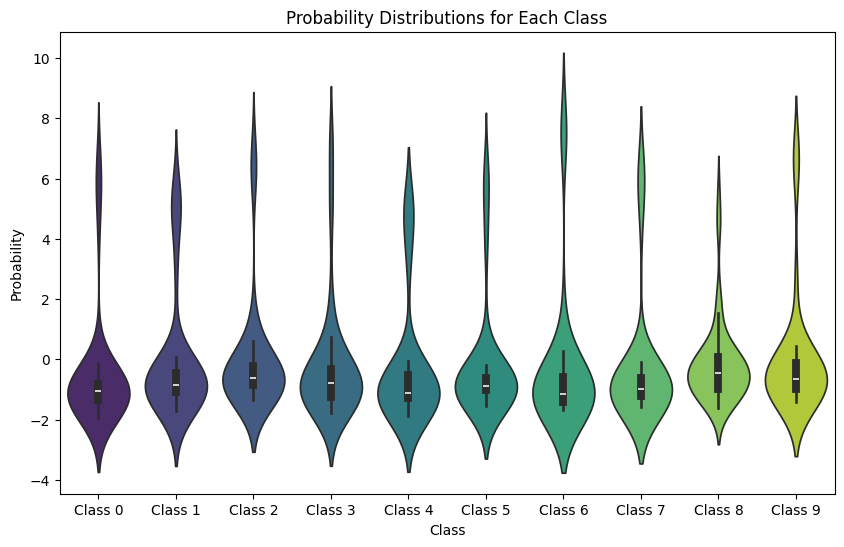

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming output is your provided list
output_tensor = one_model_outputs[0][0].numpy()

# Create a list of labels for each class
class_labels = [f'Class {i}' for i in range(output_tensor.shape[1])]

# Convert the output tensor to a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(data=output_tensor, columns=class_labels)

# Plot the probability distributions using a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability Distributions for Each Class')
plt.show()


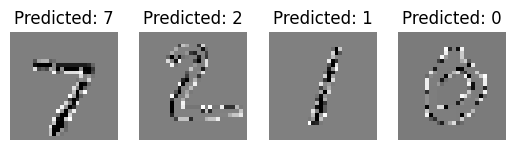

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Assuming model_output is your model's output tensor
# and input_images is a tensor containing your input images
concatenated_output = torch.cat(one_model_outputs[0], dim=0)
input_images = test_dataset.test_data.data
model_output_np = concatenated_output
# Convert the tensor to numpy array
model_output_np = model_output_np.numpy()

# Get predicted labels for each instance
predicted_labels = np.argmax(model_output_np, axis=1)

# Convert input_images to float tensor before normalization
input_images_float = input_images.float()

# Add an extra channel dimension (assuming grayscale images)
input_images_float = input_images_float.unsqueeze(1)

# Unnormalize and convert input_images to numpy array
unnormalize = transforms.Compose([transforms.Normalize(mean=-0.5/0.5, std=1/0.5),
                                 transforms.ToPILImage()])

input_images_np = np.array([np.array(unnormalize(img)) for img in input_images_float])

# Display a few images along with their predicted labels
num_images_to_display = 4

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(input_images_np[i], cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')

plt.show()


In [56]:
concatenated_output = torch.cat(one_model_outputs[0], dim=0)


10000

NameError: name 'true_labels' is not defined

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,